This is our experimentation file. Whichever augmentation technique we found to be promising, we have implementated them. You
can find all different things we have tried. We also have other notebook for different augmentations.

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import pathlib as pl

In [35]:
def noise_generation(img):
    mean = random.randint(-30, 30)
    stddev = random.randint(-180, 180)
    noise = np.zeros(img.shape, np.uint8)
    cv.randn(noise, mean, stddev)
    noisy_img = cv.add(img, noise)
    return noisy_img

In [4]:
def rotate(img, angle, center):
    center = (np.array(img.shape[1::-1]) / 2)
    rotate_mat = cv.getRotationMatrix2D(center, angle, 1)
    op = cv.warpAffine(img, rotate_mat, img.shape[1::-1], flags=cv.INTER_LINEAR)
    return op

In [5]:
def shifter(img, x, y):
    translation_mat = np.float32([
        [1, 0, x],
        [0, 1, y]
    ])
    img_shift = cv.warpAffine(img, translation_mat, (img.shape[1], img.shape[0]))
    return img_shift
    

In [6]:
def shift_stacker(img, x, y, axis=0):
    if axis == 0:
        if x < 0:
            img1 = shifter(img, x, y)
            img2 = shifter(img, x + 25, y)
        else:
            img1 = shifter(img, x, y)
            img2 = shifter(img, x - 25, y)
    else:
        if y < 0:
            img1 = shifter(img, x, y)
            img2 = shifter(img, x, y+25)
        else:
            img1 = shifter(img, x, y)
            img2 = shifter(img, x, y-25)
            
    return cv.addWeighted(img1, 0.7, img2, 0.4, 0)

In [7]:
def edge_smoother(img, val):
    if val == 100:
        blurred_img = cv.GaussianBlur(img, (21, 21), 0)
        mask = np.zeros((300, 300, 3), dtype=np.uint8)
        for i in range(300):
            for j in range(300):
                for k in range(3):
                    if j >= 80 and j <= 110:
                        pass
                    else:
                        mask[i][j][k] = 255
        out = np.where(mask==np.array([255, 255, 255]), img, blurred_img)
        return out
    else:
        blurred_img = cv.GaussianBlur(img, (21, 21), 0)
        mask = np.zeros((300, 300, 3), dtype=np.uint8)
        for i in range(300):
            for j in range(300):
                for k in range(3):
                    if j >= 180 and j <= 210:
                        pass
                    else:
                        mask[i][j][k] = 255
        out = np.where(mask==np.array([255, 255, 255]), img, blurred_img)
        return out

In [8]:
def brightness_handler(img, val):
    if val == 100:
        for i in range(300):
            for j in range(100):
                for k in range(3):
                    img[i][j][k] = 0
        return img
    elif val == 0:
        for i in range(300):
            for j in range(100, 200):
                for k in range(3):
                    img[i][j][k] = img[i][j][k] - 1
        return img
    else:
        for i in range(300):
            for j in range(200, 300):
                for k in range(3):
                    img[i][j][k] = 50
        return img

In [9]:
def brightness_lower(img, val):
    overlay_mask = np.zeros((300, 300, 3), dtype=np.uint8)
    low_bright = cv.convertScaleAbs(img, alpha=1, beta=val)
    for i in range(300):
        for j in range(100, 200):
            for k in range(3):
                overlay_mask[i][j][k] = 255
    out = np.where(overlay_mask == np.array([255, 255, 255]), low_bright, img)
    return out

In [10]:
def control_contrast(img, val):
    contrast = cv.convertScaleAbs(img, alpha=val)
    return contrast

In [11]:
def movement(img, size):
    vertical_kernel = np.zeros((size, size))
    horizontal_kernel = np.zeros((size, size))
    vertical_kernel[:, int((size-1)/2)] = 1
    horizontal_kernel[int((size-1)/2), :] = 1
    vertical_kernel = vertical_kernel/size
    horizontal_kernel = horizontal_kernel/size
    
    horizontal_mb = cv.filter2D(vertical_mb, -1, horizontal_kernel)
    return vertical_mb
    

In [12]:
def shear(img, x, y):
    factor = 0.9
    zommed = zoom(img, factor)
    mask = np.zeros((300, 300, 3), dtype=np.uint8)
    imgss = np.zeros((300, 300, 3), dtype="uint8")
    for i in range(int(300*(1-factor)/2), int(300*(factor) + 300*(1-factor)/2)):
        for j in range(int(300*(1-factor)/2), int(300*(factor) + 300*(1-factor)/2)):
            for k in range(3):
                imgss[i][j][k] = zommed[i-1 - int(300*(1-factor)/2)][j-1 - int(300*(1-factor)/2)][k]
    blurred_img = cv.GaussianBlur(imgss, (21, 21), 0)
    print(int(300*0.1)-15,int(300*0.9)+15)
    for i in range(0,300):
        for j in range(0,300):
            for k in range(3):
                if i <  20 or i > 275 or j < 20 or j > 275:
                    mask[i][j][k] = 255
    
    out = np.where(mask==np.array([255, 255, 255]), blurred_img, imgss)
    plt.imshow(out)
    plt.figure()
    matrix = np.float32([[1, x, 0],
                             [y, 1, 0],
                             [0, 0, 1]])
    sheared = cv.warpPerspective(out, matrix, (int(img.shape[0]*1.5), int(img.shape[1]*1.5)))
    return sheared

In [13]:
def zoom(img, factor=2):
    return cv.resize(img, None, fx=factor, fy=factor)

In [14]:
# def cartoonize(img):
#     gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#     gray = cv.GaussianBlur(gray, (3, 3), 0)
#     edges = cv.Laplacian(gray, -1, ksize=5)
#     edges = 255 - edges
#     ret, edges = cv.threshold(edges, 200, 255, cv.THRESH_BINARY)
#     edgePreservingImage = cv.edgePreservingFilter(img, flags=2, sigma_s=50, sigma_r = 0.8)
#     output = np.zeros(gray.shape)
#     output = cv.bitwise_and(edgePreservingImage, edgePreservingImage, mask=edges)
#     return output


def embose(img):
    height, width = img.shape[:2]
    y = np.ones((height, width), np.uint8) * 180
    output = np.zeros((height, width), np.uint8)
    # generating the kernels
    kernel1 = np.array([[0, -1, -1], # kernel for embossing bottom left side
                        [1, 0, -1],
                        [1, 1, 0]])
    kernel2 = np.array([[-1, -1, 0], # kernel for embossing bottom right side
                        [-1, 0, 1],
                        [0, 1, 1]])
    # you can generate kernels for embossing top as well
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    output1 = cv.add(cv.filter2D(gray, -1, kernel1), y) # emboss on bottom left side
    output2 = cv.add(cv.filter2D(gray, -1, kernel2), y) # emboss on bottom right side
    for i in range(height):
        for j in range(width):
            output[i, j] = max(output1[i, j], output2[i, j])
    return cv.add(img, output)


def ColourQuantization(image, K=9):
    Z = image.reshape((-1, 3)) 
    Z = np.float32(Z) 
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    compactness, label, center = cv.kmeans(Z, K, None, criteria, 1, cv.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((image.shape))
    return res2

In [15]:
def oilpaint(img):
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (6, 6))
    morph = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    result = cv.normalize(morph, None, 50, 255, cv.NORM_MINMAX)
    #result = cartoonize(result)
    return result

In [16]:
def tile_range_finder(indx):
    if indx == 0:
        return ((0, 99), (0, 99))
    elif indx == 1:
        return ((0, 99), (100, 199))
    elif indx == 2:
        return ((0, 99), (200, 299))
    elif indx == 3:
        return ((100, 199), (0, 99))
    elif indx == 4:
        return ((100, 199), (100, 199))
    elif indx == 5:
        return ((100, 199), (200, 299))
    elif indx == 6:
        return ((200, 299), (0, 99))
    elif indx == 7:
        return ((200, 299), (100, 199))
    elif indx == 8:
        return ((200, 299), (200, 299))

In [17]:
def range_writer(img, range_, img_2):
    for i in range(range_[0][0], range_[0][1]):
        for j in range(range_[1][0], range_[1][1]):
            img[i][j] = img_2[i - range_[0][0]][j - range_[1][0]]
    return img

In [18]:
def tile_swapper(img, tile1_idx, tile2_idx):
    range1 = tile_range_finder(tile1_idx)
    range2 = tile_range_finder(tile2_idx)
    temp = copy.deepcopy(img[range1[0][0]:range1[0][1],range1[1][0]:range1[1][1]])
    temp2 = img[range2[0][0]:range2[0][1],range2[1][0]:range2[1][1]]
    img = range_writer(img, range1, temp2)
    img = range_writer(img, range2, temp)
    return edge_smoother(img)

In [19]:
def edge_smoother(img):
    blurred_img = cv.GaussianBlur(img, (21, 21), 0)
    mask = np.zeros((300, 300, 3))
    for i in range(89, 119):
        for j in range(0, 300):
            for k in range(3):
                mask[i][j][k] = 255
    for i in range(189, 209):
        for j in range(0, 300):
            for k in range(3):
                mask[i][j][k] = 255
    for i in range(89, 119):
        for j in range(0, 300):
            for k in range(3):
                mask[j][i][k] = 255
    for i in range(189, 209):
        for j in range(0, 300):
            for k in range(3):
                mask[j][i][k] = 255

    out = np.where(mask==np.array([255, 255, 255]), blurred_img, img)
    return out

In [20]:
def sobel_edge(img, kernel):
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #op = cv.Canny(src=img, ddepth=cv.CV_64F, dx=1, dy=0, ksize=kernel)
    op = cv.Canny(img, 50, 200)
    return op

In [21]:
def oil_paint_effect(img):
    #img = cartoonize(img)
    res = cv.xphoto.oilPainting(img, 7, 5)
    return res

In [22]:
def equalizer(img):
    r = img[:, :, 0]
    g = img[:, :, 1]
    b = img[:, :, 2]
    r = cv.equalizeHist(r)
    g = cv.equalizeHist(g)
    b = cv.equalizeHist(b)
    new_img = cv.merge([r, g, b])
    return new_img

In [23]:
def shape_enhancer(img):
    img = cv.GaussianBlur(img, (5, 5), 0)
    img = cv.convertScaleAbs(img, alpha=1.3)
    return img

In [32]:
img = cv.imread(r"D:\Samsung Prism\Datasets\Cat and Dog\Training\Cat\cat.341.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
#img = img/255.0
img = cv.resize(img, (300, 300))

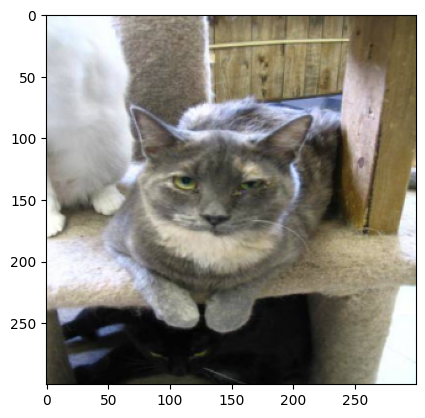

In [33]:
plt.imshow(img)

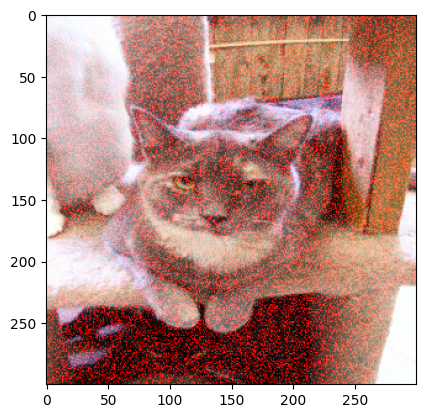

In [53]:
plt.imshow(noise_generation(img))

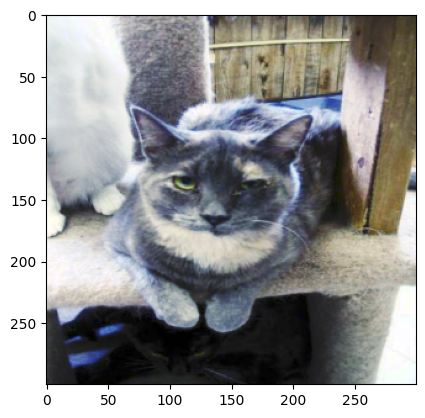

In [47]:
plt.imshow(equalizer(img))

In [260]:
path = r"D:\The Plan\TensorFlow\Datasets\Cat and Dog\Training"
pathlib_file = pl.Path(path)
class_names = np.array(sorted(item.name for item in pathlib_file.glob("*")))
save_dir = r"D:\The Plan\TensorFlow\Datasets\Cat and Dog\Tiles Shuffling\\"

In [262]:
count = 0
for each_class in class_names:
    temp_path = path + "\\" + each_class
    temp_file = list((pl.Path(temp_path)).glob("*"))
    for each_img in temp_file:
        img = cv.imread(str(each_img))
        if img is not None:
            img = cv.resize(img, (300, 300))
            new_img = copy.deepcopy(img)
            for i in range(6):
                a = random.randint(0, 8)
                b = random.randint(0, 8)
                new_img = edge_smoother(tile_swapper(new_img, a, b))
            cv.imwrite(save_dir+"augtiles" + str(count) + ".jpg", new_img)
            count += 1

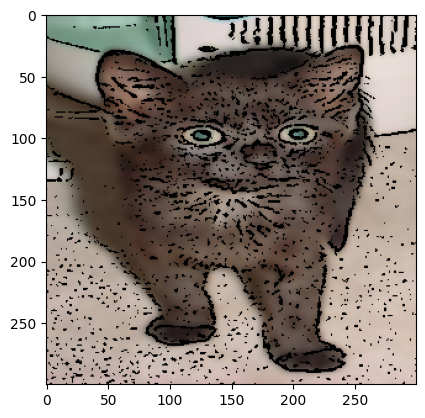

In [91]:
plt.imshow(cartoon)